# Levanto los datos

In [1]:
import pandas as pd

df = pd.read_csv('/Users/przivic/Downloads/Registro para grupos de estudio.csv')

df = df.rename(
    columns={'Conocimientos de programación': 'coding_skills', 'Conocimientos de Machine Learning': 'ml_skills'}
)

len(df)

143

# Miramos distribución de las 2 preguntas

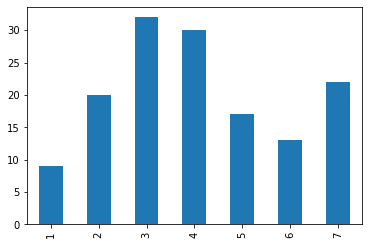

In [2]:
df.coding_skills.value_counts().sort_index().plot.bar()

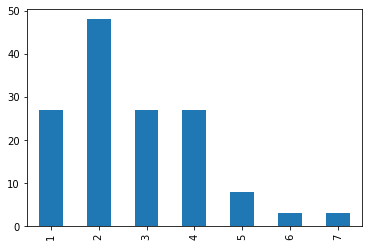

In [3]:
df.ml_skills.value_counts().sort_index().plot.bar()

In [4]:
docs = df.to_dict(orient='records')

In [5]:
import numpy as np

def max_coding_skills(group):
    # devuelve cuanto sabe la persona que mas sabe programacion del grupo
    return max([e['coding_skills'] for e in group])

def max_ml_skills(group):
    # devuelve cuanto sabe la persona que mas sabe machine learning del grupo
    return max([e['ml_skills'] for e in group])

def bottle_neck(groups):
    # devuelve la suma de _bottle_neck
    return sum(map(_bottle_neck, groups))

def _bottle_neck(group):
    # devuelve un numero positivo si hay menos de 2 personas que saben mas de 3 en alguna dimensión
    return hinge(2 - len([e for e in group if max(e[k] for k in 'coding_skills ml_skills'.split()) >= 3]))
    

def hinge(n): return max(0, n)

MIN_CODING_SKILLS = 4
MIN_ML_SKILLS = 4

def var(groups, key):
    # calcula la varianza respecto a una key
    return sum([np.std([e[key] for e in group]) for group in groups])

def loss(groups):
    return (
        # Todos los grupos tienen que tener alguien que sepa de programacion
        sum([hinge(MIN_CODING_SKILLS - max_coding_skills(g)) for g in groups]) + 
        # Todos los grupos tienen que tener alguien que sepa de machine learning
        sum([hinge(MIN_ML_SKILLS - max_ml_skills(g)) for g in groups]) +
        # Los grupos deben ser parejos en coding
        var(groups, 'coding_skills') + 
        # Los grupos deben ser parejos en machine learning
        var(groups, 'ml_skills') + 
        # Definitivamente no tiene que haber una persona que sea "la que sepa todo"
        bottle_neck(groups)
    )

In [6]:
from time import time
from random import shuffle, choice

def random_groups(docs, group_size=4):
    # Crea una asignación al azar de grupos
    shuffle(docs)
    return [docs[start:start+group_size] for start in range(0, len(docs), group_size)]

def improve_locally(current_sol):
    # Toma el peor grupo segun la loss y trata de intercambiar con otros grupos 
    current_loss = loss(current_sol)
    
    
    i, worst = max(enumerate(current_sol), key=lambda x: loss([x[1]]))
    for j, other in enumerate(current_sol):
        for wg_i, w_person in enumerate(worst):
            for o_i, o_person in enumerate(other):
                candidate = (
                    [g for k, g in enumerate(current_sol) if k not in [i, j]] + 
                    [replace(worst, wg_i, o_person), replace(other, o_i, w_person)]
                )
                
                new_loss = loss(candidate)
                if new_loss < current_loss:
                    return candidate, new_loss
                
    return current_sol, current_loss
    
def replace(group, index, person):
    res = group[:]
    res[index] = person
    return res

def get_groups(iters=50):
    groups = random_groups(docs)
    losses = []
    t0 = time()
    status = 'max_iter'
    for i in range(iters):
        if time() - t0 > 180: 
            status = 'timeout'
            print('timeout')
            break
        groups, loss = improve_locally(groups)
        if losses and losses[-1] == loss: 
            status = 'local_minima'
            break
        losses.append(loss)
        
    return groups, losses, status

In [7]:
from tqdm import tqdm

solutions = []
for i in tqdm(range(100)):
    solutions.append(get_groups(iters=150))

100%|██████████| 100/100 [15:53<00:00,  9.54s/it]


In [8]:
import pickle as pkl

with open('solutions.pkl', 'wb') as f:
    pkl.dump(solutions, f, 2)

In [9]:
best, best_losses, best_status = min(solutions, key=lambda x: x[1][-1])

In [10]:
to_save = [[e['Username'] for e in g] for g in best]
with open('groups.pkl', 'wb') as f:
    pkl.dump(to_save, f)

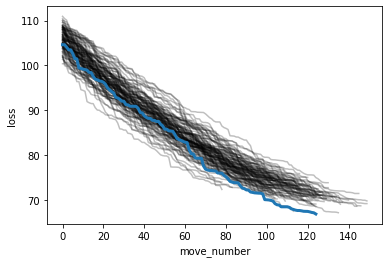

In [12]:
import matplotlib.pyplot as plt

for g, l, s in solutions:
    plt.plot(l, color='k', alpha=0.25)
    
plt.ylabel('loss')
plt.xlabel('move_number')
plt.plot(best_losses, lw=3)

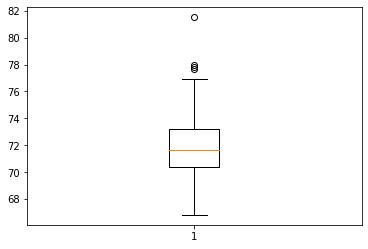

In [13]:
final_losses = [l[-1] for _, l, _ in solutions]
plt.boxplot(final_losses);

# Revisamos la mejor solucion y vemos que los grupos hayan quedado parejos

Text(0.5, 1.0, 'max ml skill per group')

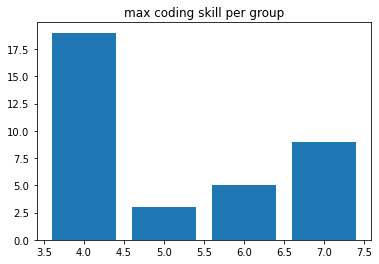

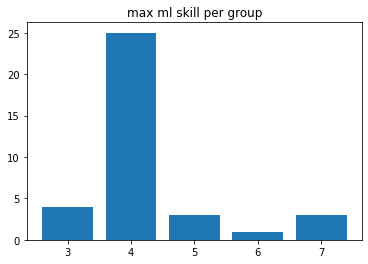

In [37]:
x, y = list(zip(*sorted(Counter(list(map(max_coding_skills, best))).items())))
plt.bar(x,y)
plt.title('max coding skill per group')

plt.figure()
x, y = list(zip(*sorted(Counter(list(map(max_ml_skills, best))).items())))
plt.bar(x,y)
plt.title('max ml skill per group');

In [14]:
from pprint import pprint

def tot_skills(g):
    return sum([e['coding_skills'] + e['ml_skills'] for e in g])

for g in sorted(best, key=tot_skills):
    pprint([{k: d[k] for k in 'ml_skills coding_skills'.split()} for d in g])
    print("*"*40)

[{'coding_skills': 4, 'ml_skills': 1},
 {'coding_skills': 2, 'ml_skills': 3},
 {'coding_skills': 1, 'ml_skills': 1},
 {'coding_skills': 1, 'ml_skills': 1}]
****************************************
[{'coding_skills': 1, 'ml_skills': 1},
 {'coding_skills': 1, 'ml_skills': 1},
 {'coding_skills': 4, 'ml_skills': 4},
 {'coding_skills': 3, 'ml_skills': 2}]
****************************************
[{'coding_skills': 1, 'ml_skills': 1},
 {'coding_skills': 4, 'ml_skills': 2},
 {'coding_skills': 2, 'ml_skills': 1},
 {'coding_skills': 3, 'ml_skills': 4}]
****************************************
[{'coding_skills': 4, 'ml_skills': 4},
 {'coding_skills': 3, 'ml_skills': 1},
 {'coding_skills': 2, 'ml_skills': 1},
 {'coding_skills': 2, 'ml_skills': 1}]
****************************************
[{'coding_skills': 4, 'ml_skills': 4},
 {'coding_skills': 3, 'ml_skills': 1},
 {'coding_skills': 2, 'ml_skills': 1},
 {'coding_skills': 2, 'ml_skills': 1}]
****************************************
[{'coding_skill